# Solver - Tutorial

## Non colliding fiber models

An important component of nerve fibers is that they are 3d objects.
Therefore, they should not overlap each other.
To achieve this, an [algorithm](https://arxiv.org/abs/1901.10284) was developed based on collision checking of conical objects.
A conical object is defined by two  neighboring points in the fiber array, i.e. fiber[i] and fiber[i+1].

The class `solver` checks a given fiber model for collisions and resolves these collisions iteratively by small displacements.

To account for the flexibility of fibers, they are continuously divided into segments. These segments are modeled geometrically as cones.

A parallel implementation of an octree is used to run the collision detection algorithm between these cones.

## General imports

First, we prepair all necesarry modules and defining a function to euqalice all three axis of an 3d plot.

In [2]:
import fastpli.model.solver
import fastpli.model.sandbox
import fastpli.io


import os

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def set_3d_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_fiber_bundles(fbs, colors):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for fb, c in zip(fbs, colors):
        for f in fb:
            plt.plot(f[:,0],f[:,1],f[:,2], c)
    set_3d_axes_equal(ax)

## Prepairing Models and defining bounding conditions

The [fiber bundles](https://github.com/3d-pli/fastpli/wiki/FiberBundles) are prepaired as shown in the sandbox examples/tutorials.
Additionally each fiber will get a random radius.

Two crossing fiber bundle (x and y) are prepaiered in this manor.

### Note
- Take note that matplotlib does not check z-buffering. Therefore each new plotted line is on top of the lines before.
That why the second fiber bundle (red) seems to be on top of the first one (blue).

- Also not be showing here.
The solver class provides an OpenGL visualization tool `solver.draw_scene()` which is not shown in this notebook since.
The example file `examples/solver.py` and [wiki](https://github.com/3d-pli/fastpli/wiki/Solver) shows its capabilities.



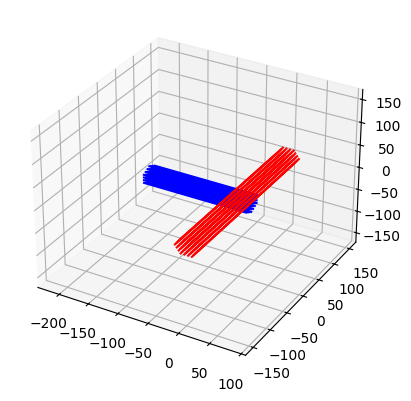

In [14]:
solver = fastpli.model.solver.Solver()

fiber_bundle_trj_x = [[-150, 0, 0], [20, 0, 0]]
fiber_bundle_trj_y = [[0, -150, 0], [0, 150, 0]]

population = fastpli.model.sandbox.seeds.triangular_circle(20, 6)

fiber_radii = np.random.uniform(2.0, 10.0, population.shape[0])
fiber_bundle_x = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_x,
                                                    population, fiber_radii)

fiber_radii = np.random.uniform(2.0, 10.0, population.shape[0])
fiber_bundle_y = fastpli.model.sandbox.build.bundle(fiber_bundle_trj_y,
                                                    population, fiber_radii)

fiber_bundles = [fiber_bundle_x, fiber_bundle_y]

plot_fiber_bundles(fiber_bundles, ['b', 'r'])
plt.show()

## Running solver

The solver algorithm splits each fiber into almost equal fiber segments allowing to seperate the model more naturally.
The mean length of this segments is controlled via `solver.obj_mean_length`.
Since the fiber segments will move in each step of the algorithm, the curviture of the fibers can increase quite fast.
To limit this a maximal curviture radii of the fibers can be set via `solver.obj_min_radius`.
This means that a "circle" of point `p_i-1, p_i` and `p_i+1` is limited by a lower value.
Is the value exceeded, the betroffende fiber segments are corrected slightly.

If all conditions are fullfiled, the output is marked as solved and the model can be used for further processing.

solved: 836, 608/0


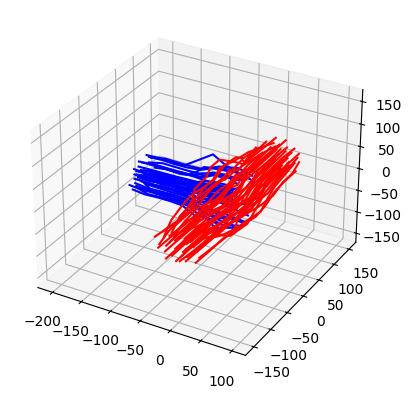

In [15]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 10
solver.obj_mean_length = 30

N = 1000
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()

## Saving

The resulting configuration can be save in a `.dat` file or `.h5` (HDF5) file wich is supported via this toolbox.

In [17]:
fastpli.io.fiber_bundles.save('output.h5', solver.fiber_bundles, mode='w')

## Additional manipulations

A trick to allow for more randomness is to apply more varrity to the fiber models at the beginning of the solver alrogithm. 
However since the boundry conditions i. e. curviture and mean fiber segment length is usually not set when initializing the models, one can apply the boundry conditions to the currently set models inside the solver object.And can then be afterward manipulated

(2, 4)
(9, 4)


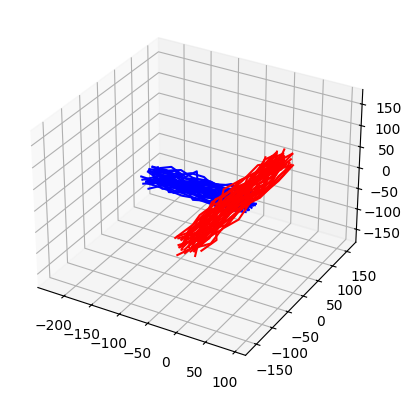

solved: 666, 685/0


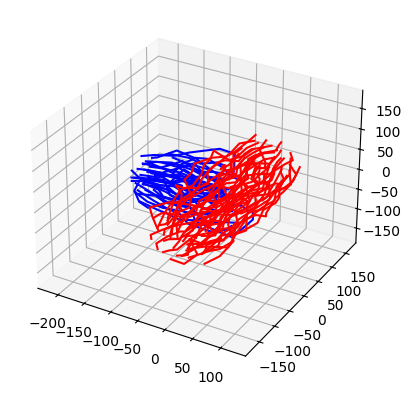

In [18]:
# run solver
solver.fiber_bundles = fiber_bundles
solver.obj_min_radius = 10
solver.obj_mean_length = 30
solver.apply_boundary_conditions(n_max=10)
print(fiber_bundles[0][0].shape)
print(solver.fiber_bundles[0][0].shape)

fbs = solver.fiber_bundles
for i, fb in enumerate(fbs):
    for j, _ in enumerate(fb):
        fbs[i][j][:,:3] += np.random.uniform(-10,10,(fbs[i][j].shape[0],3))
        fbs[i][j][:,3] *= np.random.uniform(0.5,2,(fbs[i][j].shape[0]))
plot_fiber_bundles(fbs, ['b', 'r'])
plt.show()

N = 1000
solver.fiber_bundles = fbs
for i in range(N):
    solved = solver.step()
    if solved:
        break
    print(f'{i/N*100:.2f}%', end='\r')
print(f'solved: {i}, {solver.num_obj}/{solver.num_col_obj}')

plot_fiber_bundles(solver.fiber_bundles, ['b', 'r'])
plt.show()


## Orientation histogram

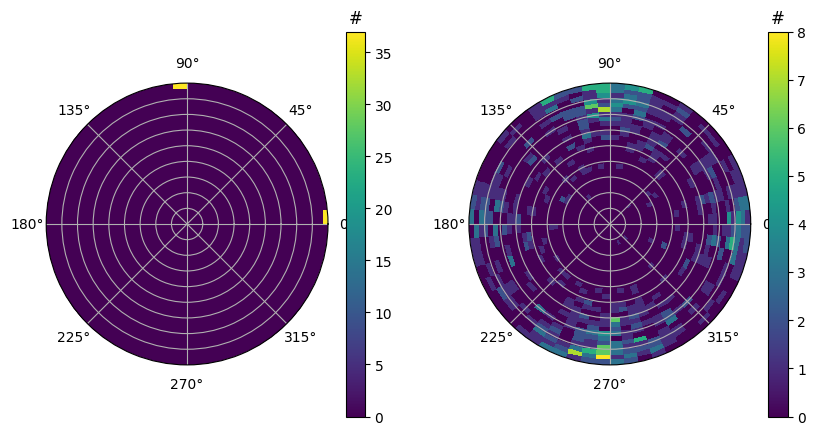

In [19]:
import fastpli.analysis

_, axs = plt.subplots(1,2, subplot_kw=dict(projection='polar'), figsize=(10,5))


pcs=[None, None]
phi, theta = fastpli.analysis.orientation.fiber_bundles(fiber_bundles)
_, _, _, pcs[0] = fastpli.analysis.orientation.histogram(phi,
                                                     theta,
                                                     ax=axs[0],
                                                     n_phi=60,
                                                     n_theta=30,
                                                     weight_area=False)

phi, theta = fastpli.analysis.orientation.fiber_bundles(solver.fiber_bundles)
_, _, _, pcs[1] = fastpli.analysis.orientation.histogram(phi,
                                                     theta,
                                                     ax=axs[1],
                                                     n_phi=60,
                                                     n_theta=30,
                                                     weight_area=False)                                                     

for ax, pc in zip(axs, pcs):
    cbar = plt.colorbar(pc, ax=ax)
    cbar.ax.set_title('#')
    ax.set_rmax(90)
    ax.set_rticks(range(0, 90, 10))
    ax.set_rlabel_position(22.5)
    ax.set_yticklabels([])
    ax.grid(True)

plt.show()